In [0]:
# Project Goal: Using the available data from yelp, build a prediction model to predict which businesses will start doing delivery/takeout after the first lockdown.

# Team Members:
#    FANG Anbing
#    LAGO Jenie Marie
#    YANG Zhou

In [0]:
# Set all necessary sources here
path_covid_features = "/FileStore/tables/yelp2/parsed_covid_sample.json"
path_yelp_business = "/FileStore/tables/yelp2/parsed_business_sample.json"
path_yelp_checkin = "/FileStore/tables/yelp2/parsed_checkin_sample.json"
path_yelp_review = "/FileStore/tables/parsed_review_sample.json"
path_yelp_tip = "/FileStore/tables/yelp2/parsed_tip_sample.json"
path_yelp_user = "/FileStore/tables/yelp2/parsed_user_sample.json"

In [0]:
# Imports
from pyspark.sql.functions import count
from pyspark.sql.types import StructField, StructType, StringType, BooleanType
from pyspark.sql.functions import isnan, when, count, col, lower, when, to_timestamp, array_contains
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline

In [0]:
# Load the json file
df_covid_features = spark.read.format("json")\
  .option("inferSchema","true")\
  .load(path_covid_features)

In [0]:
# Reference: https://www.yelp.com/dataset/documentation/main
df_covid_features.printSchema()

root
-- Call To Action enabled: string (nullable = true)
-- Covid Banner: string (nullable = true)
-- Grubhub enabled: string (nullable = true)
-- Request a Quote Enabled: string (nullable = true)
-- Temporary Closed Until: string (nullable = true)
-- Virtual Services Offered: string (nullable = true)
-- business_id: string (nullable = true)
-- delivery or takeout: string (nullable = true)
-- highlights: string (nullable = true)

In [0]:
# Get shape of dataframe
print((df_covid_features.count(), len(df_covid_features.columns)))

(19053, 9)

In [0]:
# Check the number of unique business IDs
df_covid_features.select('business_id').distinct().count()

Out[122]: 19018

In [0]:
# Drop duplicates
df_covid_features = df_covid_features.dropDuplicates(['business_id'])
df_covid_features.select('business_id').distinct().count()

Out[123]: 19018

In [0]:
df_covid_features.show(3)

+----------------------+------------+---------------+-----------------------+----------------------+------------------------+--------------------+-------------------+----------+
Call To Action enabled|Covid Banner|Grubhub enabled|Request a Quote Enabled|Temporary Closed Until|Virtual Services Offered| business_id|delivery or takeout|highlights|
+----------------------+------------+---------------+-----------------------+----------------------+------------------------+--------------------+-------------------+----------+
 TRUE| FALSE| FALSE| FALSE| FALSE| FALSE|-00iClV0kYHkvipph...| FALSE| FALSE|
 TRUE| FALSE| FALSE| FALSE| FALSE| FALSE|-0FA-Qdi3SPYIoJz9...| FALSE| FALSE|
 FALSE| FALSE| FALSE| FALSE| FALSE| FALSE|-0KMvRFwDWdVBeTpT...| TRUE| FALSE|
+----------------------+------------+---------------+-----------------------+----------------------+------------------------+--------------------+-------------------+----------+
only showing top 3 rows

In [0]:
# Count the number of nulls per column
df_covid_features.select([count(when(col(c).isNull(), c)).alias(c) for c in df_covid_features.columns]).show()

+----------------------+------------+---------------+-----------------------+----------------------+------------------------+-----------+-------------------+----------+
Call To Action enabled|Covid Banner|Grubhub enabled|Request a Quote Enabled|Temporary Closed Until|Virtual Services Offered|business_id|delivery or takeout|highlights|
+----------------------+------------+---------------+-----------------------+----------------------+------------------------+-----------+-------------------+----------+
 0| 0| 0| 0| 0| 0| 0| 0| 0|
+----------------------+------------+---------------+-----------------------+----------------------+------------------------+-----------+-------------------+----------+

In [0]:
# Rename all the columns, remove spaces for easier calling in the next steps
df_covid_features = df_covid_features.select([col(c).alias(c.replace(' ', '_')) for c in df_covid_features.columns])

In [0]:
# Reload View
df_covid_features.createOrReplaceTempView("df_covid_features")

In [0]:
# Inspect columns that do not look boolean
spark.sql("""
  select distinct Covid_Banner
          from df_covid_features
""").show(5)

+--------------------+
 Covid_Banner|
+--------------------+
 FALSE|
Ed's is still ope...|
Now serving our b...|
We're Open and Re...|
We care deeply ab...|
+--------------------+
only showing top 5 rows

In [0]:
spark.sql("""
  select distinct Temporary_Closed_Until
          from df_covid_features
""").show(5, truncate = False)

+------------------------+
Temporary_Closed_Until |
+------------------------+
FALSE |
2020-06-30T00:00:00.000Z|
2020-07-06T00:00:00.000Z|
2020-08-01T00:00:00.000Z|
2020-08-31T00:00:00.000Z|
+------------------------+
only showing top 5 rows

In [0]:
spark.sql("""
  select distinct Virtual_Services_Offered
          from df_covid_features
""").show(15, truncate = False)

+-------------------------------+
Virtual_Services_Offered |
+-------------------------------+
FALSE |
offers_virtual_tasting_sessions|
offers_virtual_experiences |
offers_virtual_tours |
offers_virtual_performances |
offers_virtual_classes |
offers_virtual_consultations |
+-------------------------------+

In [0]:
spark.sql("""
  select distinct highlights
          from df_covid_features
""").show(5, truncate = False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
highlights |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
FALSE |
[{"identifier":"gift_cards_during_covid_19","params":{},"type":"covid"},{"identifier":"delivery_during_covid_19","params":{},"type":"covid"},{"identifier":"curbside_pickup_during_covid_19","params":{},"type":"covid"},{"identifier":"takeout_during_covid_19","params":{},"type":"covid"}] |
[{"identifier":"takeout_during_covid_19","params":{},"type":"covid"},{"identifier":"delivery_during_covid_19","params":{},"type":"covid"},{"identifier":"gift_cards_during_covid_19","params":{},"type":"covid"},{"identifier":"healthy_dining","params":{},"type":"dining_options"},{"identifier":"kid_friendly","params":{},"type":"crowd"}]|
[{"identifier":"gift_cards_during_covid_19","params":{},"type":"covid"},{"identifier":"online_classes_during_covid_19","params":{},"type":"covid"}] |
[{"identifier":"delivery_during_covid_19","params":{},"type":"covid"},{"identifier":"budget_friendly","params":{},"type":"pricing"}] |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
only showing top 5 rows

In [0]:
# change to lower case the columns identified as boolean
df_covid_features = df_covid_features.withColumn("Call_To_Action_enabled",lower(col("Call_To_Action_enabled")))\
                      .withColumn("Grubhub_enabled",lower(col("Grubhub_enabled")))\
                      .withColumn("Request_a_Quote_Enabled",lower(col("Request_a_Quote_Enabled")))\
                      .withColumn("delivery_or_takeout",lower(col("delivery_or_takeout")))

df_covid_features.show(5)

+----------------------+------------+---------------+-----------------------+----------------------+------------------------+--------------------+-------------------+----------+
Call_To_Action_enabled|Covid_Banner|Grubhub_enabled|Request_a_Quote_Enabled|Temporary_Closed_Until|Virtual_Services_Offered| business_id|delivery_or_takeout|highlights|
+----------------------+------------+---------------+-----------------------+----------------------+------------------------+--------------------+-------------------+----------+
 true| FALSE| false| false| FALSE| FALSE|-00iClV0kYHkvipph...| false| FALSE|
 true| FALSE| false| false| FALSE| FALSE|-0FA-Qdi3SPYIoJz9...| false| FALSE|
 false| FALSE| false| false| FALSE| FALSE|-0KMvRFwDWdVBeTpT...| true| FALSE|
 true| FALSE| false| false| FALSE| FALSE|-0LPtgJC31FWMrMv3...| false| FALSE|
 false| FALSE| false| false| FALSE| FALSE|-0T0jfPnuBRdpNTXp...| true| FALSE|
+----------------------+------------+---------------+-----------------------+----------------------+------------------------+--------------------+-------------------+----------+
only showing top 5 rows

In [0]:
df_covid_features = df_covid_features.withColumn("Call_To_Action_enabled",col("Call_To_Action_enabled").cast(BooleanType()))\
    .withColumn("Grubhub_enabled",col("Grubhub_enabled").cast(BooleanType())) \
    .withColumn("Request_a_Quote_Enabled",col("Request_a_Quote_Enabled").cast(BooleanType())) \
    .withColumn("delivery_or_takeout",col("delivery_or_takeout").cast(BooleanType()))

In [0]:
# Count the number of nulls per column, check if cast of all columns successful
df_covid_features.select([count(when(col(c).isNull(), c)).alias(c) for c in df_covid_features.columns]).show()

+----------------------+------------+---------------+-----------------------+----------------------+------------------------+-----------+-------------------+----------+
Call_To_Action_enabled|Covid_Banner|Grubhub_enabled|Request_a_Quote_Enabled|Temporary_Closed_Until|Virtual_Services_Offered|business_id|delivery_or_takeout|highlights|
+----------------------+------------+---------------+-----------------------+----------------------+------------------------+-----------+-------------------+----------+
 0| 0| 0| 0| 0| 0| 0| 0| 0|
+----------------------+------------+---------------+-----------------------+----------------------+------------------------+-----------+-------------------+----------+

In [0]:
# Create _isWithText for the string columns, it was noticed that some columns have FALSE and string values with them. Create a flag for businesses who actually filled out said columns
cols_string = ["Covid_Banner", "Temporary_Closed_Until", "Virtual_Services_Offered", "highlights"]

for col_name in cols_string:
  col_name_new = col_name + "_withText"
  df_covid_features = df_covid_features.withColumn(col_name_new, when(col(col_name)== 'FALSE', 0).otherwise(1))

In [0]:
# Check values of those columns with actual text
df_covid_features.filter(df_covid_features.Virtual_Services_Offered_withText == 1).show(5)

+----------------------+--------------------+---------------+-----------------------+----------------------+------------------------+--------------------+-------------------+--------------------+---------------------+-------------------------------+---------------------------------+-------------------+
Call_To_Action_enabled| Covid_Banner|Grubhub_enabled|Request_a_Quote_Enabled|Temporary_Closed_Until|Virtual_Services_Offered| business_id|delivery_or_takeout| highlights|Covid_Banner_withText|Temporary_Closed_Until_withText|Virtual_Services_Offered_withText|highlights_withText|
+----------------------+--------------------+---------------+-----------------------+----------------------+------------------------+--------------------+-------------------+--------------------+---------------------+-------------------------------+---------------------------------+-------------------+
 false| FALSE| false| false| FALSE| offers_virtual_tours|-H4OGa8w3baQgXKmH...| false| FALSE| 0| 0| 1| 0|
 true|As a preventative...| false| false| 2020-08-01T00:00:...| offers_virtual_cl...|-eocJ0ugt1rEDZj16...| false|[{"identifier":"g...| 1| 1| 1| 1|
 false|In light of the c...| false| false| FALSE| offers_virtual_co...|-hipP74BQsEFa2WnD...| false|[{"identifier":"r...| 1| 0| 1| 1|
 true|Our team is avail...| false| false| FALSE| offers_virtual_tours|-htftQXo17AVLzeR7...| false|[{"identifier":"r...| 1| 0| 1| 1|
 false| FALSE| false| false| FALSE| offers_virtual_co...|-roOqXSD88puXRij6...| false| FALSE| 0| 0| 1| 0|
+----------------------+--------------------+---------------+-----------------------+----------------------+------------------------+--------------------+-------------------+--------------------+---------------------+-------------------------------+---------------------------------+-------------------+
only showing top 5 rows

In [0]:
# String indexer for Virtual_Services_Offered
lblIndxr = StringIndexer().setInputCol("Virtual_Services_Offered").setOutputCol("VSOInd")

# Perform OneHotEncoding for the Virtual_Services_Offered column
ohee_catv = OneHotEncoder().setInputCol("VSOInd").setOutputCol("VSO_dum")

# Pipeline
pipe_catv = Pipeline(stages=[lblIndxr, ohee_catv])

In [0]:
df_covid_features = pipe_catv.fit(df_covid_features).transform(df_covid_features)
df_covid_features = df_covid_features.drop("VSOInd")
df_covid_features.show(3)

+----------------------+------------+---------------+-----------------------+----------------------+------------------------+--------------------+-------------------+----------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+
Call_To_Action_enabled|Covid_Banner|Grubhub_enabled|Request_a_Quote_Enabled|Temporary_Closed_Until|Virtual_Services_Offered| business_id|delivery_or_takeout|highlights|Covid_Banner_withText|Temporary_Closed_Until_withText|Virtual_Services_Offered_withText|highlights_withText| VSO_dum|
+----------------------+------------+---------------+-----------------------+----------------------+------------------------+--------------------+-------------------+----------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+
 true| FALSE| false| false| FALSE| FALSE|-00iClV0kYHkvipph...| false| FALSE| 0| 0| 0| 0|(6,[0],[1.0])|
 true| FALSE| false| false| FALSE| FALSE|-0FA-Qdi3SPYIoJz9...| false| FALSE| 0| 0| 0| 0|(6,[0],[1.0])|
 false| FALSE| false| false| FALSE| FALSE|-0KMvRFwDWdVBeTpT...| true| FALSE| 0| 0| 0| 0|(6,[0],[1.0])|
+----------------------+------------+---------------+-----------------------+----------------------+------------------------+--------------------+-------------------+----------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+
only showing top 3 rows

In [0]:
# Drop some string columns, To-DO: In the future we can analyze the content of the strings
drop_cols = cols_string

df_covid_features = df_covid_features.drop(*drop_cols)
df_covid_features.printSchema()

root
-- Call_To_Action_enabled: boolean (nullable = true)
-- Grubhub_enabled: boolean (nullable = true)
-- Request_a_Quote_Enabled: boolean (nullable = true)
-- business_id: string (nullable = true)
-- delivery_or_takeout: boolean (nullable = true)
-- Covid_Banner_withText: integer (nullable = false)
-- Temporary_Closed_Until_withText: integer (nullable = false)
-- Virtual_Services_Offered_withText: integer (nullable = false)
-- highlights_withText: integer (nullable = false)
-- VSO_dum: vector (nullable = true)

In [0]:
df_covid_features.groupBy("delivery_or_takeout").count().show()

+-------------------+-----+
delivery_or_takeout|count|
+-------------------+-----+
 true| 6224|
 false|12794|
+-------------------+-----+

In [0]:
# Update sql view
df_covid_features.createOrReplaceTempView("df_covid_features")

In [0]:
df_covid_features.show(5)

+----------------------+---------------+-----------------------+--------------------+-------------------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+
Call_To_Action_enabled|Grubhub_enabled|Request_a_Quote_Enabled| business_id|delivery_or_takeout|Covid_Banner_withText|Temporary_Closed_Until_withText|Virtual_Services_Offered_withText|highlights_withText| VSO_dum|
+----------------------+---------------+-----------------------+--------------------+-------------------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+
 true| false| false|-00iClV0kYHkvipph...| false| 0| 0| 0| 0|(6,[0],[1.0])|
 true| false| false|-0FA-Qdi3SPYIoJz9...| false| 0| 0| 0| 0|(6,[0],[1.0])|
 false| false| false|-0KMvRFwDWdVBeTpT...| true| 0| 0| 0| 0|(6,[0],[1.0])|
 true| false| false|-0LPtgJC31FWMrMv3...| false| 0| 0| 0| 0|(6,[0],[1.0])|
 false| false| false|-0T0jfPnuBRdpNTXp...| true| 0| 0| 0| 0|(6,[0],[1.0])|
+----------------------+---------------+-----------------------+--------------------+-------------------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+
only showing top 5 rows

In [0]:
df_covid_features = df_covid_features.withColumn("label",col("delivery_or_takeout").cast("double")).drop("delivery_or_takeout")
df_covid_features = df_covid_features.withColumn("Grubhub_enabled",col("Grubhub_enabled").cast("double"))
df_covid_features = df_covid_features.withColumn("Request_a_Quote_Enabled",col("Request_a_Quote_Enabled").cast("double"))
df_covid_features = df_covid_features.withColumn("Request_a_Quote_Enabled",col("Request_a_Quote_Enabled").cast("double"))
df_covid_features = df_covid_features.withColumn("Call_To_Action_enabled",col("Call_To_Action_enabled").cast("double"))

In [0]:
df_covid_features.show(5)

+----------------------+---------------+-----------------------+--------------------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+-----+
Call_To_Action_enabled|Grubhub_enabled|Request_a_Quote_Enabled| business_id|Covid_Banner_withText|Temporary_Closed_Until_withText|Virtual_Services_Offered_withText|highlights_withText| VSO_dum|label|
+----------------------+---------------+-----------------------+--------------------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+-----+
 1.0| 0.0| 0.0|-00iClV0kYHkvipph...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0|
 1.0| 0.0| 0.0|-0FA-Qdi3SPYIoJz9...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0|
 0.0| 0.0| 0.0|-0KMvRFwDWdVBeTpT...| 0| 0| 0| 0|(6,[0],[1.0])| 1.0|
 1.0| 0.0| 0.0|-0LPtgJC31FWMrMv3...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0|
 0.0| 0.0| 0.0|-0T0jfPnuBRdpNTXp...| 0| 0| 0| 0|(6,[0],[1.0])| 1.0|
+----------------------+---------------+-----------------------+--------------------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+-----+
only showing top 5 rows

In [0]:
df_covid_features.groupBy("label").count().show()

+-----+-----+
label|count|
+-----+-----+
 0.0|12794|
 1.0| 6224|
+-----+-----+

In [0]:
# Save covid features to base table
df_final_base = df_covid_features

In [0]:
df_final_base.createOrReplaceTempView("df_final_base")

In [0]:
# Load file
df_business = spark.read.format("json")\
  .option("inferSchema", "true")\
  .option("header","true")\
  .load(path_yelp_business)

In [0]:
df_business.createOrReplaceTempView("df_business")

In [0]:
# Check how many of the businesses exist on the covid features
df_business_filtered = spark.sql("""
    SELECT * FROM df_business 
    WHERE business_id IN (
      SELECT business_id from df_covid_features
    )
""")

In [0]:
print((df_business_filtered.count(), len(df_business_filtered.columns)))

(19018, 58)

In [0]:
df_business_filtered.createOrReplaceTempView("df_business_filtered")

In [0]:
df_business_filtered.groupBy("delivery_mention").count().show()

In [0]:
business_feature=df_business_filtered[["business_id","categories","city","state","is_open","review_count","stars"]]
business_feature.show(5)

+--------------------+--------------------+-------------+-----+-------+------------+-----+
 business_id| categories| city|state|is_open|review_count|stars|
+--------------------+--------------------+-------------+-----+-------+------------+-----+
-00iClV0kYHkvipph...|Hair Salons, Blow...| Etobicoke| ON| 1| 8| 4.0|
-0FA-Qdi3SPYIoJz9...|Hair Salons, Beau...| Markham| ON| 1| 14| 4.0|
-0KMvRFwDWdVBeTpT...| Restaurants, Pizza|Richmond Hill| ON| 1| 3| 2.5|
-0LPtgJC31FWMrMv3...|Banks & Credit Un...| Akron| OH| 1| 5| 3.0|
-0T0jfPnuBRdpNTXp...|Food, Coffee & Te...| Markham| ON| 1| 6| 1.5|
+--------------------+--------------------+-------------+-----+-------+------------+-----+
only showing top 5 rows

In [0]:
business_feature.select([count(when(col(c).isNull(), c)).alias(c) for c in business_feature.columns]).show()

+-----------+----------+----+-----+-------+------------+-----+
business_id|categories|city|state|is_open|review_count|stars|
+-----------+----------+----+-----+-------+------------+-----+
 0| 39| 0| 0| 0| 0| 0|
+-----------+----------+----+-----+-------+------------+-----+

In [0]:
business_feature = business_feature.na.fill(value='Missing')

In [0]:
business_feature.select([count(when(col(c).isNull(), c)).alias(c) for c in business_feature.columns]).show()

+-----------+----------+----+-----+-------+------------+-----+
business_id|categories|city|state|is_open|review_count|stars|
+-----------+----------+----+-----+-------+------------+-----+
 0| 0| 0| 0| 0| 0| 0|
+-----------+----------+----+-----+-------+------------+-----+

In [0]:
#categories,city,state
CatrIndxr = StringIndexer().setInputCol("categories").setOutputCol("categoriesInd")
cityIndxr = StringIndexer().setInputCol("city").setOutputCol("cityInd")
stateIndxr = StringIndexer().setInputCol("state").setOutputCol("stateInd")

#One-hot encoding
ohee_catv = OneHotEncoder(inputCols=["categoriesInd","cityInd","stateInd"],outputCols=["categories_dum","city_dum","state_dum"])
pipe_catv = Pipeline(stages=[CatrIndxr, cityIndxr,stateIndxr, ohee_catv])

In [0]:
business_feature = pipe_catv.fit(business_feature).transform(business_feature)
business_feature = business_feature.drop("categoriesInd","cityInd","stateInd")
business_feature = business_feature.drop("categories","city","state")

In [0]:
business_feature = business_feature.withColumnRenamed("business_id", "b_business_id")

In [0]:
business_feature.show(3)

+--------------------+-------+------------+-----+--------------------+----------------+--------------+
 b_business_id|is_open|review_count|stars| categories_dum| city_dum| state_dum|
+--------------------+-------+------------+-----+--------------------+----------------+--------------+
-00iClV0kYHkvipph...| 1| 8| 4.0|(12241,[6047],[1.0])|(494,[30],[1.0])|(15,[2],[1.0])|
-0FA-Qdi3SPYIoJz9...| 1| 14| 4.0| (12241,[9],[1.0])|(494,[18],[1.0])|(15,[2],[1.0])|
-0KMvRFwDWdVBeTpT...| 1| 3| 2.5| (12241,[0],[1.0])|(494,[26],[1.0])|(15,[2],[1.0])|
+--------------------+-------+------------+-----+--------------------+----------------+--------------+
only showing top 3 rows

In [0]:
business_feature.createOrReplaceTempView("business_feature")

In [0]:
df_final_base = spark.sql("""
    SELECT f.*, b.*
    from df_final_base f
    LEFT JOIN business_feature b ON f.business_id == b.b_business_id
""")

In [0]:
df_final_base = df_final_base.na.fill(value=0)

In [0]:
df_final_base = df_final_base.drop('b_business_id')

In [0]:
df_final_base.createOrReplaceTempView("df_final_base")

In [0]:
df_final_base.show(5)

--------------------------------------------------------------------------- 
 Py4JJavaError Traceback (most recent call last)
 <command-3625872603520912> in <module> 
 ----> 1 df_final_base . show ( 5 ) 

 /databricks/spark/python/pyspark/sql/dataframe.py in show (self, n, truncate, vertical) 
 488 """
 489 if isinstance ( truncate , bool ) and truncate : 
 --> 490 print ( self . _jdf . showString ( n , 20 , vertical ) ) 
 491 else : 
 492 print ( self . _jdf . showString ( n , int ( truncate ) , vertical ) ) 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1302 
 1303 answer = self . gateway_client . send_command ( command ) 
 -> 1304 return_value = get_return_value(
 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 108 def deco ( * a , ** kw ) : 
 109 try : 
 --> 110 return f ( * a , ** kw ) 
 111 except py4j . protocol . Py4JJavaError as e : 
 112 converted = convert_exception ( e . java_exception ) 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/protocol.py in get_return_value (answer, gateway_client, target_id, name) 
 324 value = OUTPUT_CONVERTER [ type ] ( answer [ 2 : ] , gateway_client ) 
 325 if answer [ 1 ] == REFERENCE_TYPE : 
 --> 326 raise Py4JJavaError(
 327 "An error occurred while calling {0}{1}{2}.\n" . 
 328 format(target_id, ".", name), value)

 Py4JJavaError : An error occurred while calling o6152.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 1088.0 failed 1 times, most recent failure: Lost task 0.0 in stage 1088.0 (TID 1112) (ip-10-172-226-127.us-west-2.compute.internal executor driver): org.apache.spark.SparkException: Failed to execute user defined function(StringIndexerModel$$Lambda$6045/707437577: (string) => double)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage6.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:754)
	at org.apache.spark.sql.execution.collect.UnsafeRowBatchUtils$.encodeUnsafeRows(UnsafeRowBatchUtils.scala:80)
	at org.apache.spark.sql.execution.collect.Collector.$anonfun$processFunc$1(Collector.scala:178)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.doRunTask(Task.scala:150)
	at org.apache.spark.scheduler.Task.run(Task.scala:119)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$10(Executor.scala:732)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1643)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:735)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: StringIndexer encountered NULL value. To handle or skip NULLS, try setting StringIndexer.handleInvalid.
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1(StringIndexer.scala:397)
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1$adapted(StringIndexer.scala:392)
	... 14 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2711)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2658)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2652)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala

In [0]:
# Load file
df_checkin = spark.read.format("json")\
  .option("inferSchema", "true")\
  .option("header","true")\
  .load(path_yelp_checkin)

In [0]:
df_checkin.printSchema()

root
-- business_id: string (nullable = true)
-- date: string (nullable = true)

In [0]:
df_checkin.show(5)

+--------------------+--------------------+
 business_id| date|
+--------------------+--------------------+
hihud--QRriCYZw1z...| 2013-03-17 00:41:53|
hihud--QRriCYZw1z...| 2013-03-17 02:41:06|
hihud--QRriCYZw1z...| 2013-03-18 06:26:54|
hihud--QRriCYZw1z...| 2013-03-19 00:13:05|
hihud--QRriCYZw1z...| 2013-03-23 04:27:56|
+--------------------+--------------------+
only showing top 5 rows

In [0]:
df_checkin.createOrReplaceTempView("df_checkin")

In [0]:
# Get only checkins for 2019
df_checkin_count_2019 = spark.sql("""
  SELECT business_id , count(business_id) as checkin_count
  FROM df_checkin
  where date > '2019-01-01'
  group by business_id
""")

In [0]:
df_checkin_count_2019.createOrReplaceTempView("df_checkin_count_2019")

In [0]:
# Get businesses checki, that exist on the covid features table
df_checkin_filtered = spark.sql("""
    SELECT * FROM df_checkin_count_2019 
    WHERE business_id IN (
      SELECT business_id from df_covid_features
    )
""")

In [0]:
# Get shape of filtered checkin dataframe
print((df_checkin_filtered.count(), len(df_checkin_filtered.columns)))

(306, 2)

In [0]:
df_checkin_filtered.show(5)

+--------------------+-------------+
 business_id|checkin_count|
+--------------------+-------------+
DloBjCZHlz0lzsrQJ...| 1|
OGkOiPuixtFgxtLyT...| 1|
vQGZjrDiDBuznOkUe...| 1|
sFGvZfFuHsbvM361o...| 1|
0SkcMNYPdZin1lu0T...| 1|
+--------------------+-------------+
only showing top 5 rows

In [0]:
df_checkin_filtered.createOrReplaceTempView("df_checkin_filtered")

In [0]:
# Merge checkin with basetable
df_final_base = spark.sql("""
    SELECT f.*, c.checkin_count
    from df_final_base f
    LEFT JOIN df_checkin_filtered c ON f.business_id == c.business_id
""")

In [0]:
print((df_final_base.count(), len(df_final_base.columns)))

(19018, 11)

In [0]:
# Count the number of nulls per column
df_final_base.select([count(when(col(c).isNull(), c)).alias(c) for c in df_final_base.columns]).show()

+----------------------+---------------+-----------------------+-----------+---------------------+-------------------------------+---------------------------------+-------------------+-------+-----+-------------+
Call_To_Action_enabled|Grubhub_enabled|Request_a_Quote_Enabled|business_id|Covid_Banner_withText|Temporary_Closed_Until_withText|Virtual_Services_Offered_withText|highlights_withText|VSO_dum|label|checkin_count|
+----------------------+---------------+-----------------------+-----------+---------------------+-------------------------------+---------------------------------+-------------------+-------+-----+-------------+
 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 18712|
+----------------------+---------------+-----------------------+-----------+---------------------+-------------------------------+---------------------------------+-------------------+-------+-----+-------------+

In [0]:
df_final_base = df_final_base.na.fill(value=0)

In [0]:
# Count the number of nulls per column after fillna
df_final_base.select([count(when(col(c).isNull(), c)).alias(c) for c in df_final_base.columns]).show()

+----------------------+---------------+-----------------------+-----------+---------------------+-------------------------------+---------------------------------+-------------------+-------+-----+-------------+
Call_To_Action_enabled|Grubhub_enabled|Request_a_Quote_Enabled|business_id|Covid_Banner_withText|Temporary_Closed_Until_withText|Virtual_Services_Offered_withText|highlights_withText|VSO_dum|label|checkin_count|
+----------------------+---------------+-----------------------+-----------+---------------------+-------------------------------+---------------------------------+-------------------+-------+-----+-------------+
 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0|
+----------------------+---------------+-----------------------+-----------+---------------------+-------------------------------+---------------------------------+-------------------+-------+-----+-------------+

In [0]:
df_final_base.createOrReplaceTempView("df_final_base")

In [0]:
# Load the file. NOTE: This is 6GB of data, loading may take time
df_review = spark.read.format("json")\
  .option("inferSchema", "true")\
  .option("header","true")\
  .load(path_yelp_review)

In [0]:
df_review.printSchema()

root
-- business_id: string (nullable = true)
-- cool: long (nullable = true)
-- date: string (nullable = true)
-- funny: long (nullable = true)
-- review_id: string (nullable = true)
-- stars: long (nullable = true)
-- text: string (nullable = true)
-- useful: long (nullable = true)
-- user_id: string (nullable = true)

In [0]:
df_review.show(3)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
 business_id|cool| date|funny| review_id|stars| text|useful| user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
-MhfebM0QIsKt87iD...| 0|2015-04-15 05:21:16| 0|xQY8N_XvtGbearJ5X...| 2|As someone who ha...| 5|OwjRMXRC0KyPrIlcj...|
lbrU8StCq3yDfr-QM...| 0|2013-12-07 03:16:52| 1|UmFMZ8PyXZTY2Qcwz...| 1|I am actually hor...| 1|nIJD_7ZXHq-FX8byP...|
HQl28KMwrEKHqhFrr...| 0|2015-12-05 03:18:11| 0|LG2ZaYiOgpr2DK_90...| 5|I love Deagan's. ...| 1|V34qejxNsCbcgD8C0...|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
only showing top 3 rows

In [0]:
# Convert date to actual timestamp
df_review = df_review.withColumn("date",to_timestamp(col("date"),"yyyy-M-d H:mm:ss"))
df_review.printSchema()

root
-- business_id: string (nullable = true)
-- cool: long (nullable = true)
-- date: timestamp (nullable = true)
-- funny: long (nullable = true)
-- review_id: string (nullable = true)
-- stars: long (nullable = true)
-- text: string (nullable = true)
-- useful: long (nullable = true)
-- user_id: string (nullable = true)

In [0]:
df_review.show(3)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
 business_id|cool| date|funny| review_id|stars| text|useful| user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
-MhfebM0QIsKt87iD...| 0|2015-04-15 05:21:16| 0|xQY8N_XvtGbearJ5X...| 2|As someone who ha...| 5|OwjRMXRC0KyPrIlcj...|
lbrU8StCq3yDfr-QM...| 0|2013-12-07 03:16:52| 1|UmFMZ8PyXZTY2Qcwz...| 1|I am actually hor...| 1|nIJD_7ZXHq-FX8byP...|
HQl28KMwrEKHqhFrr...| 0|2015-12-05 03:18:11| 0|LG2ZaYiOgpr2DK_90...| 5|I love Deagan's. ...| 1|V34qejxNsCbcgD8C0...|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
only showing top 3 rows

In [0]:
df_review.createOrReplaceTempView("df_review")

In [0]:
spark.sql("SELECT min(date), max(date) FROM df_review").show()

+-------------------+-------------------+
 min(date)| max(date)|
+-------------------+-------------------+
2005-01-24 22:21:29|2019-09-07 17:33:34|
+-------------------+-------------------+

In [0]:
# With the below min and max result, we filter out recent reviews for 2019 only
# +-------------------+-------------------+
# |          min(date)|          max(date)|
# +-------------------+-------------------+
# |2005-01-24 22:21:29|2019-09-07 17:33:34|
# +-------------------+-------------------+
df_review_filtered = spark.sql("""
    SELECT * FROM df_review 
    WHERE date > '2019-01-01' AND 
    business_id IN (
      SELECT business_id from df_covid_features
    )
""")

In [0]:
df_review_filtered.count()

Out[57]: 6956

In [0]:
df_review_filtered.createOrReplaceTempView("df_review_filtered")

In [0]:
# Check minimum data it should show June as the earliest review
spark.sql("SELECT min(date), max(date) FROM df_review_filtered").show()

+-------------------+-------------------+
 min(date)| max(date)|
+-------------------+-------------------+
2019-01-01 00:22:01|2019-09-07 17:33:34|
+-------------------+-------------------+

In [0]:
df_review_filtered.show(3)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
 business_id|cool| date|funny| review_id|stars| text|useful| user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
5eV8oUGdBXylwB7He...| 0|2019-01-02 19:11:49| 0|Vx-DPb4olxt1Zxf9d...| 4|Top notch cuisine...| 0|Donht4mLJ4aO4FQhq...|
wSAGILK2CFbq5BVZ5...| 0|2019-01-02 15:40:41| 0|zAz8R8quJi2_dPffs...| 4|It pains me to gi...| 0|BgMzrzJtDYK-yUuoJ...|
xkKFDW3-fhXVu_4Qj...| 0|2019-01-07 20:38:15| 0|KpRy2ztU1jcfwoTta...| 5|We had so much fu...| 0|se1Pp_z2fNx09k_9Y...|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
only showing top 3 rows

In [0]:
# Check grouping of star rating
spark.sql("SELECT stars, count(*) FROM df_review_filtered group by stars").show()

+-----+--------+
stars|count(1)|
+-----+--------+
 5| 3645|
 1| 1204|
 3| 559|
 2| 448|
 4| 1100|
+-----+--------+

In [0]:
# Flag reviews that contain the "deliver"

# Change text review to lower case
df_review_filtered = df_review_filtered.withColumn("text",lower(col("text")))

In [0]:
# Find text with delivery and takeout
# Points for improvement: Use proper lemmatization
#search_text = 'delivery' and 'takeout'

df_review_filtered = df_review_filtered.withColumn('delivery_mention', when(col("text").contains('deliver'), 1).otherwise(0))
df_review_filtered = df_review_filtered.withColumn('takeout_mention', when(col("text").contains('takeout'), 1).otherwise(0))

In [0]:
df_review_filtered.groupBy("delivery_mention").count().show()

+----------------+-----+
delivery_mention|count|
+----------------+-----+
 1| 189|
 0| 6767|
+----------------+-----+

In [0]:
df_review_filtered.groupBy("takeout_mention").count().show()

+---------------+-----+
takeout_mention|count|
+---------------+-----+
 1| 33|
 0| 6923|
+---------------+-----+

In [0]:
df_review_filtered.show(3)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+----------------+---------------+
 business_id|cool| date|funny| review_id|stars| text|useful| user_id|delivery_mention|takeout_mention|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+----------------+---------------+
5eV8oUGdBXylwB7He...| 0|2019-01-02 19:11:49| 0|Vx-DPb4olxt1Zxf9d...| 4|top notch cuisine...| 0|Donht4mLJ4aO4FQhq...| 0| 0|
wSAGILK2CFbq5BVZ5...| 0|2019-01-02 15:40:41| 0|zAz8R8quJi2_dPffs...| 4|it pains me to gi...| 0|BgMzrzJtDYK-yUuoJ...| 0| 0|
xkKFDW3-fhXVu_4Qj...| 0|2019-01-07 20:38:15| 0|KpRy2ztU1jcfwoTta...| 5|we had so much fu...| 0|se1Pp_z2fNx09k_9Y...| 0| 0|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+----------------+---------------+
only showing top 3 rows

In [0]:
from pyspark.ml.feature import SQLTransformer

# Create SQL Transformer
sql_transformation = SQLTransformer()\
  .setStatement("""
    SELECT business_id as r_business_id, avg(cool) as avg_cool, sum(cool) as sum_cool,
        avg(funny) as avg_funny, sum(funny) as sum_funny,
        avg(stars) as avg_stars, sum(stars) as sum_stars,
        avg(useful) as avg_useful, sum(useful) as sum_useful,
        sum(delivery_mention) as delivery_mention,
        sum(takeout_mention) as takeout_mention,
        count(*) as review_count
    FROM __THIS__
    GROUP BY business_id
  """)

In [0]:
df_review_transformed = sql_transformation.transform(df_review_filtered)

In [0]:
df_review_transformed.show(2)

+--------------------+--------+--------+---------+-------------+-----------------+-------------+----------+--------------+----------------+---------------+------------+
 r_business_id|avg_cool|sum_cool|avg_funny|sum_avg_funny| avg_stars|sum_avg_stars|avg_useful|sum_avg_useful|delivery_mention|takeout_mention|review_count|
+--------------------+--------+--------+---------+-------------+-----------------+-------------+----------+--------------+----------------+---------------+------------+
fdBB7vuO3NnMps5DZ...| 0.0| 0| 0.0| 0|4.666666666666667| 14| 0.0| 0| 0| 0| 3|
x1fx7C_tc064cFATj...| 0.0| 0| 0.0| 0| 1.5| 3| 0.0| 0| 0| 0| 2|
+--------------------+--------+--------+---------+-------------+-----------------+-------------+----------+--------------+----------------+---------------+------------+
only showing top 2 rows

In [0]:
# Merge with base table
print(df_final_base.count())
print(df_review_transformed.count())

19018
3243

In [0]:
df_final_base.createOrReplaceTempView("df_final_base")
df_review_transformed.createOrReplaceTempView("df_review_transformed")

In [0]:
# Merge with base table
df_final_base = spark.sql("""
    SELECT f.*, r.*
    from df_final_base f
    LEFT JOIN df_review_transformed r ON f.business_id == r.r_business_id
""")

In [0]:
df_final_base = df_final_base.drop("r_business_id")

In [0]:
# fill rows with no reviews with 0
df_final_base = df_final_base.na.fill(value=0)

In [0]:
# Update view
df_final_base.createOrReplaceTempView("df_final_base")

In [0]:
print((df_final_base.count(), len(df_final_base.columns)))

(19018, 22)

In [0]:
# Load file
df_tip = spark.read.format("json")\
  .option("inferSchema", "true")\
  .option("header","true")\
  .load(path_yelp_tip)

In [0]:
df_tip.show(2)

+--------------------+----------------+-------------------+--------------------+--------------------+
 business_id|compliment_count| date| text| user_id|
+--------------------+----------------+-------------------+--------------------+--------------------+
rcaPajgKOJC2vo_l3...| 0|2012-05-29 02:05:56|Kelly is an aweso...|2hdR7KYAmnCk2FjTn...|
-wDNRL4lm1UgeFLG9...| 0|2016-04-19 09:33:45|Great food. Been ...|XhGn2quN9IzMI4HkM...|
+--------------------+----------------+-------------------+--------------------+--------------------+
only showing top 2 rows

In [0]:
df_tip.createOrReplaceTempView("df_tip")

In [0]:
df_tip_filtered = spark.sql("""
    SELECT * FROM df_tip 
    WHERE business_id IN (
      SELECT business_id from df_covid_features
    )
""")

In [0]:
# Get shape of filtered tip dataframe
print((df_tip_filtered.count(), len(df_tip_filtered.columns)))

(124161, 5)

In [0]:
df_tip_filtered.select("business_id").distinct().count()

Out[82]: 12578

In [0]:
df_tip_filtered.show(2)

+--------------------+----------------+-------------------+--------------------+--------------------+
 business_id|compliment_count| date| text| user_id|
+--------------------+----------------+-------------------+--------------------+--------------------+
rcaPajgKOJC2vo_l3...| 0|2012-05-29 02:05:56|Kelly is an aweso...|2hdR7KYAmnCk2FjTn...|
-wDNRL4lm1UgeFLG9...| 0|2016-04-19 09:33:45|Great food. Been ...|XhGn2quN9IzMI4HkM...|
+--------------------+----------------+-------------------+--------------------+--------------------+
only showing top 2 rows

In [0]:
df_tip_filtered.createOrReplaceTempView("df_tip_filtered")

In [0]:
# Get info of tips
df_tip_filtered_2019 = spark.sql("""
  SELECT business_id , avg(compliment_count) as avg_number_of_compliment , sum(compliment_count) as total_number_of_compliment, count(*) as total_tip_row
  FROM df_tip_filtered
  WHERE date >= '2019-01-01'
  group by business_id
""")

In [0]:
# To-Do: Get user information

In [0]:
df_tip_filtered_2019.createOrReplaceTempView("df_tip_filtered_2019")

In [0]:
df_tip_filtered_2019.select("business_id").distinct().count()

Out[87]: 2889

In [0]:
# Join tip with basetable
df_final_base = spark.sql("""
    SELECT f.*, t.avg_number_of_compliment, t.total_number_of_compliment, t.total_tip_row
    from df_final_base f
    LEFT JOIN df_tip_filtered_2019 t ON f.business_id == t.business_id
""")

In [0]:
print((df_final_base.count(), len(df_final_base.columns)))

(19018, 25)

In [0]:
df_final_base.select([count(when(col(c).isNull(), c)).alias(c) for c in df_final_base.columns]).show()

+----------------------+---------------+-----------------------+-----------+---------------------+-------------------------------+---------------------------------+-------------------+-------+-----+-------------+--------+--------+---------+-------------+---------+-------------+----------+--------------+----------------+---------------+------------+------------------------+--------------------------+-------------+
Call_To_Action_enabled|Grubhub_enabled|Request_a_Quote_Enabled|business_id|Covid_Banner_withText|Temporary_Closed_Until_withText|Virtual_Services_Offered_withText|highlights_withText|VSO_dum|label|checkin_count|avg_cool|sum_cool|avg_funny|sum_avg_funny|avg_stars|sum_avg_stars|avg_useful|sum_avg_useful|delivery_mention|takeout_mention|review_count|avg_number_of_compliment|total_number_of_compliment|total_tip_row|
+----------------------+---------------+-----------------------+-----------+---------------------+-------------------------------+---------------------------------+-------------------+-------+-----+-------------+--------+--------+---------+-------------+---------+-------------+----------+--------------+----------------+---------------+------------+------------------------+--------------------------+-------------+
 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 16129| 16129| 16129|
+----------------------+---------------+-----------------------+-----------+---------------------+-------------------------------+---------------------------------+-------------------+-------+-----+-------------+--------+--------+---------+-------------+---------+-------------+----------+--------------+----------------+---------------+------------+------------------------+--------------------------+-------------+

In [0]:
df_final_base = df_final_base.na.fill(value=0)

In [0]:
df_final_base.select([count(when(col(c).isNull(), c)).alias(c) for c in df_final_base.columns]).show()

+----------------------+---------------+-----------------------+-----------+---------------------+-------------------------------+---------------------------------+-------------------+-------+-----+-------------+--------+--------+---------+-------------+---------+-------------+----------+--------------+----------------+---------------+------------+------------------------+--------------------------+-------------+
Call_To_Action_enabled|Grubhub_enabled|Request_a_Quote_Enabled|business_id|Covid_Banner_withText|Temporary_Closed_Until_withText|Virtual_Services_Offered_withText|highlights_withText|VSO_dum|label|checkin_count|avg_cool|sum_cool|avg_funny|sum_avg_funny|avg_stars|sum_avg_stars|avg_useful|sum_avg_useful|delivery_mention|takeout_mention|review_count|avg_number_of_compliment|total_number_of_compliment|total_tip_row|
+----------------------+---------------+-----------------------+-----------+---------------------+-------------------------------+---------------------------------+-------------------+-------+-----+-------------+--------+--------+---------+-------------+---------+-------------+----------+--------------+----------------+---------------+------------+------------------------+--------------------------+-------------+
 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0|
+----------------------+---------------+-----------------------+-----------+---------------------+-------------------------------+---------------------------------+-------------------+-------+-----+-------------+--------+--------+---------+-------------+---------+-------------+----------+--------------+----------------+---------------+------------+------------------------+--------------------------+-------------+

In [0]:
df_final_base.createOrReplaceTempView("df_final_base")

In [0]:
df_final_base.show()

+----------------------+---------------+-----------------------+--------------------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+-----+-------------+--------+--------+---------+-------------+---------+-------------+----------+--------------+----------------+---------------+------------+------------------------+--------------------------+-------------+
Call_To_Action_enabled|Grubhub_enabled|Request_a_Quote_Enabled| business_id|Covid_Banner_withText|Temporary_Closed_Until_withText|Virtual_Services_Offered_withText|highlights_withText| VSO_dum|label|checkin_count|avg_cool|sum_cool|avg_funny|sum_avg_funny|avg_stars|sum_avg_stars|avg_useful|sum_avg_useful|delivery_mention|takeout_mention|review_count|avg_number_of_compliment|total_number_of_compliment|total_tip_row|
+----------------------+---------------+-----------------------+--------------------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+-----+-------------+--------+--------+---------+-------------+---------+-------------+----------+--------------+----------------+---------------+------------+------------------------+--------------------------+-------------+
 1.0| 0.0| 0.0|-00iClV0kYHkvipph...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0|
 1.0| 0.0| 0.0|-0FA-Qdi3SPYIoJz9...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 3.0| 3| 0.0| 0| 0| 0| 1| 0.0| 0| 1|
 0.0| 0.0| 0.0|-0KMvRFwDWdVBeTpT...| 0| 0| 0| 0|(6,[0],[1.0])| 1.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0|
 1.0| 0.0| 0.0|-0LPtgJC31FWMrMv3...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0|
 0.0| 0.0| 0.0|-0T0jfPnuBRdpNTXp...| 0| 0| 0| 0|(6,[0],[1.0])| 1.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0|
 0.0| 0.0| 0.0|-0aOudcaAyac0VJbM...| 0| 0| 0| 0|(6,[0],[1.0])| 1.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0|
 1.0| 0.0| 0.0|-0mgn9dRi95otXd_h...| 0| 0| 0| 0|(6,[0],[1.0])| 1.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0|
 0.0| 0.0| 0.0|-0nEqS3_A_nnUut4D...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0|
 0.0| 0.0| 0.0|-1E2CQu_38mkghvmZ...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 1| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0|
 0.0| 0.0| 0.0|-1MVd6ljY2JT6gCKn...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 1|
 0.0| 0.0| 0.0|-1TUzO4XCmOeqi9eA...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0|
 0.0| 0.0| 0.0|-1W8v_0LVdvXMtynN...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0|
 0.0| 0.0| 0.0|-2AQs-KdwG5QCwGBS...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 1.0| 1| 0.0| 0| 0| 0| 1| 0.0| 0| 0|
 0.0| 0.0| 0.0|-2R--HQiUyvN4qld5...| 0| 0| 0| 0|(6,[0],[1.0])| 1.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0|
 0.0| 0.0| 0.0|-2ToCaDFpTNmmg3QF...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0|
 0.0| 0.0| 0.0|-2UWYfzeK65e6naWS...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0|
 0.0| 0.0| 0.0|-2WsPmC49gP3RRk2U...| 1| 0| 0| 1|(6,[0],[1.0])| 1.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0|
 1.0| 0.0| 0.0|-2X9U7v-Avoib-ki0...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0|
 0.0| 0.0| 0.0|-2hDBMaza_ldqnZdi...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 9|
 1.0| 0.0| 0.0|-2uUrtgM5fiOaCpQE...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0|
+----------------------+---------------+-----------------------+--------------------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+-----+-------------+--------+--------+---------+---

In [0]:
df_final_base.select([count(when(col(c).isNull(), c)).alias(c) for c in df_final_base.columns]).show()

+----------------------+---------------+-----------------------+-----------+---------------------+-------------------------------+---------------------------------+-------------------+-------+-----+-------------+--------+--------+---------+-------------+---------+-------------+----------+--------------+----------------+---------------+------------+------------------------+--------------------------+-------------+
Call_To_Action_enabled|Grubhub_enabled|Request_a_Quote_Enabled|business_id|Covid_Banner_withText|Temporary_Closed_Until_withText|Virtual_Services_Offered_withText|highlights_withText|VSO_dum|label|checkin_count|avg_cool|sum_cool|avg_funny|sum_avg_funny|avg_stars|sum_avg_stars|avg_useful|sum_avg_useful|delivery_mention|takeout_mention|review_count|avg_number_of_compliment|total_number_of_compliment|total_tip_row|
+----------------------+---------------+-----------------------+-----------+---------------------+-------------------------------+---------------------------------+-------------------+-------+-----+-------------+--------+--------+---------+-------------+---------+-------------+----------+--------------+----------------+---------------+------------+------------------------+--------------------------+-------------+
 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0|
+----------------------+---------------+-----------------------+-----------+---------------------+-------------------------------+---------------------------------+-------------------+-------+-----+-------------+--------+--------+---------+-------------+---------+-------------+----------+--------------+----------------+---------------+------------+------------------------+--------------------------+-------------+

In [0]:
df_user = spark.read.format("json")\
  .option("inferSchema", "true")\
  .option("header","true")\
  .load(path_yelp_user)

In [0]:
df_user.printSchema()

root
-- average_stars: double (nullable = true)
-- compliment_cool: long (nullable = true)
-- compliment_cute: long (nullable = true)
-- compliment_funny: long (nullable = true)
-- compliment_hot: long (nullable = true)
-- compliment_list: long (nullable = true)
-- compliment_more: long (nullable = true)
-- compliment_note: long (nullable = true)
-- compliment_photos: long (nullable = true)
-- compliment_plain: long (nullable = true)
-- compliment_profile: long (nullable = true)
-- compliment_writer: long (nullable = true)
-- cool: long (nullable = true)
-- elite: string (nullable = true)
-- fans: long (nullable = true)
-- friends: string (nullable = true)
-- funny: long (nullable = true)
-- name: string (nullable = true)
-- review_count: long (nullable = true)
-- useful: long (nullable = true)
-- user_id: string (nullable = true)
-- yelping_since: string (nullable = true)

In [0]:
from pyspark.ml.feature import RFormula

In [0]:
# Replace final basetable once we have merged the others
basetable_final = df_final_base
#basetable_final = df_covid_features

In [0]:
basetable_final.show(5)

+----------------------+---------------+-----------------------+--------------------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+-----+-------------+--------+--------+---------+-------------+---------+-------------+----------+--------------+----------------+---------------+------------+------------------------+--------------------------+-------------+
Call_To_Action_enabled|Grubhub_enabled|Request_a_Quote_Enabled| business_id|Covid_Banner_withText|Temporary_Closed_Until_withText|Virtual_Services_Offered_withText|highlights_withText| VSO_dum|label|checkin_count|avg_cool|sum_cool|avg_funny|sum_avg_funny|avg_stars|sum_avg_stars|avg_useful|sum_avg_useful|delivery_mention|takeout_mention|review_count|avg_number_of_compliment|total_number_of_compliment|total_tip_row|
+----------------------+---------------+-----------------------+--------------------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+-----+-------------+--------+--------+---------+-------------+---------+-------------+----------+--------------+----------------+---------------+------------+------------------------+--------------------------+-------------+
 1.0| 0.0| 0.0|-00iClV0kYHkvipph...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0|
 1.0| 0.0| 0.0|-0FA-Qdi3SPYIoJz9...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 3.0| 3| 0.0| 0| 0| 0| 1| 0.0| 0| 1|
 0.0| 0.0| 0.0|-0KMvRFwDWdVBeTpT...| 0| 0| 0| 0|(6,[0],[1.0])| 1.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0|
 1.0| 0.0| 0.0|-0LPtgJC31FWMrMv3...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0|
 0.0| 0.0| 0.0|-0T0jfPnuBRdpNTXp...| 0| 0| 0| 0|(6,[0],[1.0])| 1.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0|
+----------------------+---------------+-----------------------+--------------------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+-----+-------------+--------+--------+---------+-------------+---------+-------------+----------+--------------+----------------+---------------+------------+------------------------+--------------------------+-------------+
only showing top 5 rows

In [0]:
#Create a train and test set with a 70% train, 30% test split
basetable_train, basetable_test = basetable_final.randomSplit([0.7, 0.3],seed=123)

In [0]:
print(basetable_train.count())
print(basetable_test.count())

13280
5738

In [0]:
from pyspark.ml.feature import RFormula

trainBig = RFormula(formula="label ~ . - business_id").fit(basetable_final).transform(basetable_final)
train = RFormula(formula="label ~ . - business_id").fit(basetable_train).transform(basetable_train)
test = RFormula(formula="label ~ . - business_id").fit(basetable_test).transform(basetable_test)

In [0]:
trainBig.show()

+----------------------+---------------+-----------------------+--------------------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+-----+-------------+--------+--------+---------+-------------+---------+-------------+----------+--------------+----------------+---------------+------------+------------------------+--------------------------+-------------+--------------------+
Call_To_Action_enabled|Grubhub_enabled|Request_a_Quote_Enabled| business_id|Covid_Banner_withText|Temporary_Closed_Until_withText|Virtual_Services_Offered_withText|highlights_withText| VSO_dum|label|checkin_count|avg_cool|sum_cool|avg_funny|sum_avg_funny|avg_stars|sum_avg_stars|avg_useful|sum_avg_useful|delivery_mention|takeout_mention|review_count|avg_number_of_compliment|total_number_of_compliment|total_tip_row| features|
+----------------------+---------------+-----------------------+--------------------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+-----+-------------+--------+--------+---------+-------------+---------+-------------+----------+--------------+----------------+---------------+------------+------------------------+--------------------------+-------------+--------------------+
 1.0| 0.0| 0.0|-00iClV0kYHkvipph...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0|(28,[0,7],[1.0,1.0])|
 1.0| 0.0| 0.0|-0FA-Qdi3SPYIoJz9...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 3.0| 3| 0.0| 0| 0| 0| 1| 0.0| 0| 1|(28,[0,7,18,19,24...|
 0.0| 0.0| 0.0|-0KMvRFwDWdVBeTpT...| 0| 0| 0| 0|(6,[0],[1.0])| 1.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 1.0| 0.0| 0.0|-0LPtgJC31FWMrMv3...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0|(28,[0,7],[1.0,1.0])|
 0.0| 0.0| 0.0|-0T0jfPnuBRdpNTXp...| 0| 0| 0| 0|(6,[0],[1.0])| 1.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-0aOudcaAyac0VJbM...| 0| 0| 0| 0|(6,[0],[1.0])| 1.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 1.0| 0.0| 0.0|-0mgn9dRi95otXd_h...| 0| 0| 0| 0|(6,[0],[1.0])| 1.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0|(28,[0,7],[1.0,1.0])|
 0.0| 0.0| 0.0|-0nEqS3_A_nnUut4D...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-1E2CQu_38mkghvmZ...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 1| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0|(28,[7,13],[1.0,1...|
 0.0| 0.0| 0.0|-1MVd6ljY2JT6gCKn...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 1|(28,[7,27],[1.0,1...|
 0.0| 0.0| 0.0|-1TUzO4XCmOeqi9eA...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-1W8v_0LVdvXMtynN...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-2AQs-KdwG5QCwGBS...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 1.0| 1| 0.0| 0| 0| 0| 1| 0.0| 0| 0|(28,[7,18,19,24],...|
 0.0| 0.0| 0.0|-2R--HQiUyvN4qld5...| 0| 0| 0| 0|(6,[0],[1.0])| 1.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-2ToCaDFpTNmmg3QF...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-2UWYfzeK65e6naWS...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-2WsPmC49gP3RRk2U...| 1| 0| 0| 1|(6,[0],[1.0])| 1.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0|(28,[3,6,7],[1.0,...|
 1.0| 0.0| 0.0|-2X9U7v-Avoib-ki0...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0|(28,[0,7],[1.0,1.0])|
 0.0| 0.0| 0.0|-2hDBMaza_ldqnZdi...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0|

In [0]:
train.show()

+----------------------+---------------+-----------------------+--------------------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+-----+-------------+--------+--------+---------+-------------+---------+-------------+----------+--------------+----------------+---------------+------------+------------------------+--------------------------+-------------+--------------------+
Call_To_Action_enabled|Grubhub_enabled|Request_a_Quote_Enabled| business_id|Covid_Banner_withText|Temporary_Closed_Until_withText|Virtual_Services_Offered_withText|highlights_withText| VSO_dum|label|checkin_count|avg_cool|sum_cool|avg_funny|sum_avg_funny|avg_stars|sum_avg_stars|avg_useful|sum_avg_useful|delivery_mention|takeout_mention|review_count|avg_number_of_compliment|total_number_of_compliment|total_tip_row| features|
+----------------------+---------------+-----------------------+--------------------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+-----+-------------+--------+--------+---------+-------------+---------+-------------+----------+--------------+----------------+---------------+------------+------------------------+--------------------------+-------------+--------------------+
 0.0| 0.0| 0.0|-0KMvRFwDWdVBeTpT...| 0| 0| 0| 0|(6,[0],[1.0])| 1.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-0T0jfPnuBRdpNTXp...| 0| 0| 0| 0|(6,[0],[1.0])| 1.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-0nEqS3_A_nnUut4D...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-1E2CQu_38mkghvmZ...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 1| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0|(28,[7,13],[1.0,1...|
 0.0| 0.0| 0.0|-1MVd6ljY2JT6gCKn...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 1|(28,[7,27],[1.0,1...|
 0.0| 0.0| 0.0|-1W8v_0LVdvXMtynN...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-2AQs-KdwG5QCwGBS...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 1.0| 1| 0.0| 0| 0| 0| 1| 0.0| 0| 0|(28,[7,18,19,24],...|
 0.0| 0.0| 0.0|-2ToCaDFpTNmmg3QF...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-2UWYfzeK65e6naWS...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-2uYjztVuVZpkTNAC...| 0| 0| 0| 0|(6,[0],[1.0])| 1.0| 0| 0.0| 0| 0.0| 0| 2.0| 2| 0.0| 0| 0| 0| 1| 0.0| 0| 0|(28,[7,18,19,24],...|
 0.0| 0.0| 0.0|-3N9tPWHfr0FHGSU3...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 1|(28,[7,27],[1.0,1...|
 0.0| 0.0| 0.0|-3QHAylnVB-vNmCg2...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-3wL_tPRfJoCRf8rW...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 1| 0.0| 0| 0.0| 0| 3.0| 3| 1.0| 1| 0| 0| 1| 0.0| 0| 0|(28,[7,13,18,19,2...|
 0.0| 0.0| 0.0|-4mowOKV3xGyfgQBh...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-55Fcc4v2sQ51422n...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-59dl6bXMKpmv38To...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-5CXrj2zoTVcZG9Nd...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-7-uHFjQLH_uxPauY...| 0| 0| 0| 0|(6,[0],[1.0])| 1.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-74zTQjLpOTzgvPTs...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.

In [0]:
test.show()

+----------------------+---------------+-----------------------+--------------------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+-----+-------------+--------+--------+---------+-------------+---------+-------------+----------+--------------+----------------+---------------+------------+------------------------+--------------------------+-------------+--------------------+
Call_To_Action_enabled|Grubhub_enabled|Request_a_Quote_Enabled| business_id|Covid_Banner_withText|Temporary_Closed_Until_withText|Virtual_Services_Offered_withText|highlights_withText| VSO_dum|label|checkin_count|avg_cool|sum_cool|avg_funny|sum_avg_funny|avg_stars|sum_avg_stars|avg_useful|sum_avg_useful|delivery_mention|takeout_mention|review_count|avg_number_of_compliment|total_number_of_compliment|total_tip_row| features|
+----------------------+---------------+-----------------------+--------------------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+-----+-------------+--------+--------+---------+-------------+---------+-------------+----------+--------------+----------------+---------------+------------+------------------------+--------------------------+-------------+--------------------+
 0.0| 0.0| 0.0|-0aOudcaAyac0VJbM...| 0| 0| 0| 0|(6,[0],[1.0])| 1.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-1TUzO4XCmOeqi9eA...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-2R--HQiUyvN4qld5...| 0| 0| 0| 0|(6,[0],[1.0])| 1.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-2WsPmC49gP3RRk2U...| 1| 0| 0| 1|(6,[0],[1.0])| 1.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0|(28,[3,6,7],[1.0,...|
 0.0| 0.0| 0.0|-2hDBMaza_ldqnZdi...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 9|(28,[7,27],[1.0,9...|
 0.0| 0.0| 0.0|-4lgvwr6d8ztCPlCX...| 0| 0| 0| 0|(6,[0],[1.0])| 1.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-5DseNF-7fhUyLKbg...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-9Ff8WEoiFsw_mfmJ...| 0| 0| 0| 0|(6,[0],[1.0])| 1.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-9oV083HMbCnMVmFt...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-AHS68n6wkMuQrx3b...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-AcbvuF0P8rvLnuZJ...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-AtzcXIwEP6yO7rM9...| 0| 0| 0| 0|(6,[0],[1.0])| 1.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-BS5c6tvU9gc3JAwo...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-BbnAc9YEO6pjvJGE...| 0| 0| 0| 0|(6,[0],[1.0])| 1.0| 0| 0.0| 0| 0.0| 0| 4.5| 9| 0.0| 0| 0| 0| 2| 0.0| 0| 3|(28,[7,18,19,24,2...|
 0.0| 0.0| 0.0|-CdstAUdEvci8GeJG...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-Cg-SSXCY-HaXJMVo...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-EwVs_4fsdWoHebCO...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-FfmSy7kw1MOqVB8X...| 0| 0| 0| 0|(6,[0],[1.0])| 1.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0| 0.0|-GCM7_i_PnTt8JK8e...| 0| 0| 0| 0|(6,[0],[1.0])| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0.0| 0| 0| 0| 0| 0.0| 0| 0| (28,[7],[1.0])|
 0.0| 0.0|

In [0]:
test.select(['features','label']).show(truncate = False)

+------------------------------------------+-----+
features |label|
+------------------------------------------+-----+
(28,[7],[1.0]) |1.0 |
(28,[7],[1.0]) |0.0 |
(28,[7],[1.0]) |1.0 |
(28,[3,6,7],[1.0,1.0,1.0]) |1.0 |
(28,[7,27],[1.0,9.0]) |0.0 |
(28,[7],[1.0]) |1.0 |
(28,[7],[1.0]) |0.0 |
(28,[7],[1.0]) |1.0 |
(28,[7],[1.0]) |0.0 |
(28,[7],[1.0]) |0.0 |
(28,[7],[1.0]) |0.0 |
(28,[7],[1.0]) |1.0 |
(28,[7],[1.0]) |0.0 |
(28,[7,18,19,24,27],[1.0,4.5,9.0,2.0,3.0])|1.0 |
(28,[7],[1.0]) |0.0 |
(28,[7],[1.0]) |0.0 |
(28,[7],[1.0]) |0.0 |
(28,[7],[1.0]) |1.0 |
(28,[7],[1.0]) |0.0 |
(28,[7],[1.0]) |0.0 |
+------------------------------------------+-----+
only showing top 20 rows

In [0]:
print("trainBig nobs: " + str(trainBig.count()))
print("train nobs: " + str(train.count()))
print("test nobs: " + str(test.count()))

trainBig nobs: 19018
train nobs: 13280
test nobs: 5738

In [0]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

In [0]:
train2 = train.select(['features','label'])

In [0]:
# train = RFormula(formula="label ~ . - business_id").fit(basetable_train).transform(basetable_train)


formula = RFormula(
    formula="label ~ . - business_id - label",
    featuresCol="features")
output = formula.fit(basetable_train).transform(basetable_train)
output.select("features", "label").show()

+--------------------+-----+
 features|label|
+--------------------+-----+
 (28,[7],[1.0])| 1.0|
 (28,[7],[1.0])| 1.0|
 (28,[7],[1.0])| 0.0|
(28,[7,13],[1.0,1...| 0.0|
(28,[7,27],[1.0,1...| 0.0|
 (28,[7],[1.0])| 0.0|
(28,[7,18,19,24],...| 0.0|
 (28,[7],[1.0])| 0.0|
 (28,[7],[1.0])| 0.0|
(28,[7,18,19,24],...| 1.0|
(28,[7,27],[1.0,1...| 0.0|
 (28,[7],[1.0])| 0.0|
(28,[7,13,18,19,2...| 0.0|
 (28,[7],[1.0])| 0.0|
 (28,[7],[1.0])| 0.0|
 (28,[7],[1.0])| 0.0|
 (28,[7],[1.0])| 0.0|
 (28,[7],[1.0])| 1.0|
 (28,[7],[1.0])| 0.0|
 (28,[7],[1.0])| 0.0|
+--------------------+-----+
only showing top 20 rows

In [0]:
output

Out[109]: DataFrame[Call_To_Action_enabled: double, Grubhub_enabled: double, Request_a_Quote_Enabled: double, business_id: string, Covid_Banner_withText: int, Temporary_Closed_Until_withText: int, Virtual_Services_Offered_withText: int, highlights_withText: int, VSO_dum: vector, label: double, checkin_count: bigint, avg_cool: double, sum_cool: bigint, avg_funny: double, sum_avg_funny: bigint, avg_stars: double, sum_avg_stars: bigint, avg_useful: double, sum_avg_useful: bigint, delivery_mention: bigint, takeout_mention: bigint, review_count: bigint, avg_number_of_compliment: double, total_number_of_compliment: bigint, total_tip_row: bigint, features: vector]

In [0]:
# Try no CV
lr_nocv = LogisticRegression()
#Fit the model
lrModel_nocv = lr_nocv.fit(train)

In [0]:
lrModel_nocv.coefficients

Out[340]: DenseVector([-0.4098, 4.2371, -2.8028, -0.363, -0.6992, -0.8113, 2.1997, -0.2775, -3.6433, -2.0048, -3.8572, -6.228, 0.0, -0.6963, -0.1728, 0.316, 0.2535, -0.2291, 0.06, -0.0553, -0.0342, -0.0117, 0.3049, 8.7611, 0.2605, 0.5342, -0.613, 0.1873])

In [0]:
predictions_lr = lrModel_nocv.transform(test)

In [0]:
# Source: https://spark.apache.org/docs/2.2.0/mllib-evaluation-metrics.html

In [0]:
print("Testing set areaUnderROC: " + str(evaluator.evaluate(predictions_lr, {evaluator.metricName: "areaUnderROC"})))

Testing set areaUnderROC: 0.6955343618282406

Training set areaUnderROC: 0.6982074792092444

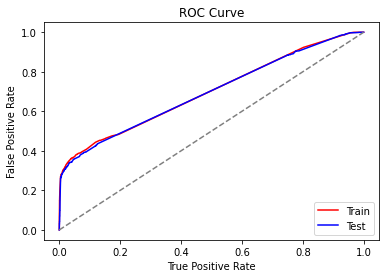

In [0]:
preds = predictions_lr.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points_lr = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points_lr]
y_val = [x[1] for x in points_lr]
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.plot(roc['FPR'],roc['TPR'], label='Train', color='red')
plt.plot(x_val, y_val, label = 'Test', color='blue')
plt.plot([0, 1], [0, 1],'r--',color='grey')
plt.legend(loc=4)
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [0]:
https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa

In [0]:
#Define pipeline
lr = LogisticRegression()
pipeline = Pipeline().setStages([lr])

In [0]:
#Set param grid
params = ParamGridBuilder()\
  .addGrid(lr.regParam, [0.01,0.1])\
  .addGrid(lr.maxIter, [50, 100])\
  .build()

# params = ParamGridBuilder()\
#   .build()

In [0]:
#Evaluator: uses max(AUC) by default to get the final model
evaluator = BinaryClassificationEvaluator()

In [0]:
# Cross-validation of entire pipeline
# Set to 10 folds as per project instruction
cv_lr = CrossValidator()\
  .setEstimator(pipeline)\
  .setEstimatorParamMaps(params)\
  .setEvaluator(evaluator)\
  .setNumFolds(10)

In [0]:
# Use the 
cvModel_lr = cv_lr.fit(train2)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
cvBestPipeline_lr = cvModel_lr.bestModel
cvBestLRModel = cvBestPipeline_lr.stages[-1]._java_obj.parent() #the stages function refers to the stage in the pipelinemodel

print("Best LR model:")
print("** regParam: " + str(cvBestLRModel.getRegParam()))
print("** maxIter: " + str(cvBestLRModel.getMaxIter()))

In [0]:
preds_lr = cvModel_lr.transform(test)\
  .select("prediction", "label")
preds_lr.show(10)

In [0]:
#Get model performance on test set
from pyspark.mllib.evaluation import BinaryClassificationMetrics

out = preds_lr.rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics_lr = BinaryClassificationMetrics(out)

print(metrics_lr.areaUnderPR) #area under precision/recall curve
print(metrics_lr.areaUnderROC)#area under Receiver Operating Characteristic curve

In [0]:
from pyspark.ml.classification import RandomForestClassifier

#Define pipeline
rfc = RandomForestClassifier()
rfPipe = Pipeline().setStages([rfc])

In [0]:
from pyspark.ml.classification import RandomForestClassifier

# Try no CV
rf_nocv = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=500, maxDepth = 5)
#Fit the model
rfModel_nocv = rf_nocv.fit(train)

In [0]:
predictions_rf = rfModel_nocv.transform(test)

In [0]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

#Get model accuracy
evaluator = BinaryClassificationEvaluator()
print("accuracy: " + str(evaluator.evaluate(predictions_rf)))

#Get AUC
metrics_rfc = BinaryClassificationMetrics(predictions_rf.rdd.map(lambda x: (float(x[0]), float(x[1]))))
print("AUC: " + str(metrics_rfc.areaUnderROC))

accuracy: 0.6881222284422199
AUC: 0.5763879916317832

In [0]:
print(rfModel_nocv)  # summary only

In [0]:
import matplotlib.pyplot as plt
import numpy as np

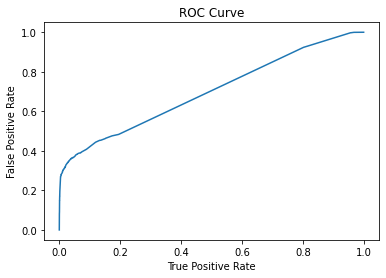

Training set areaUnderROC: 0.6982074792092444

In [0]:
trainingSummary = rfModel_nocv.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [0]:
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions_rf))

Test Area Under ROC 0.6881222284422199

In [0]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.6881222284422199

In [0]:
# Source: https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

In [0]:
# Returns as a list (false positive rate, true positive rate)
preds = predictions_rf.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

Training set areaUnderROC: 0.6982074792092444

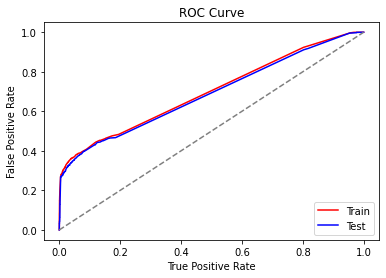

In [0]:
plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.plot(roc['FPR'],roc['TPR'], label='Train', color='red')
plt.plot(x_val, y_val, label = 'Test', color='blue')
plt.plot([0, 1], [0, 1],'r--',color='grey')
plt.legend(loc=4)
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))
#print("Testing set areaUnderROC: " + str(evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderROC"})))

In [0]:
#Set param grid
rfParams = ParamGridBuilder()\
  .addGrid(rfc.numTrees, [300, 500])\
  .build()

In [0]:
rfCv = CrossValidator()\
  .setEstimator(rfPipe)\
  .setEstimatorParamMaps(rfParams)\
  .setEvaluator(BinaryClassificationEvaluator())\
  .setNumFolds(10) 

In [0]:
#Run cross-validation, and choose the best set of parameters.
rfcModel = rfCv.fit(train)

In [0]:
cvBestPipeline_rf = rfcModel.bestModel
cvBestRFModel = cvBestPipeline_rf.stages[-1]._java_obj.parent() #the stages function refers to the stage in the pipelinemodel

print("Best RF model:")
print("** NumTrees: " + str(cvBestRFModel.getNumTrees()))

In [0]:
#Get predictions on the test set
preds_rfc = rfcModel.transform(test)
preds_rfc.show(5)

In [0]:
import pandas as pd

# Source: https://www.timlrx.com/blog/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [0]:
# List down important features
ExtractFeatureImp(cvBestPipeline_rf.stages[-1].featureImportances, preds_rfc, "features").head(10)

In [0]:
#Get model accuracy
print("accuracy: " + str(evaluator.evaluate(preds_rfc)))

#Get AUC
metrics_rfc = BinaryClassificationMetrics(preds_rfc.rdd.map(lambda x: (float(x[0]), float(x[1]))))
print("AUC: " + str(metrics_rfc.areaUnderROC))

In [0]:
from pyspark.ml.classification import GBTClassifier

#Define pipeline
gb = GBTClassifier()
gb_pipeline = Pipeline().setStages([gb])

In [0]:
#Set param grid
gbParams = ParamGridBuilder()\
  .addGrid(gb.maxDepth, [5, 10])\
  .build()
  
# Increase parameters for final tuning
#gbParams = ParamGridBuilder()\
#  .addGrid(gb.maxDepth, [5, 10])\
#  .addGrid(gb.maxBins, [20, 40])\
#  .addGrid(gb.maxIter, [10, 20])\
#  .build()  

In [0]:
gbCv = CrossValidator()\
  .setEstimator(gb_pipeline)\
  .setEstimatorParamMaps(gbParams)\
  .setEvaluator(BinaryClassificationEvaluator())\
  .setNumFolds(10) 

In [0]:
#Run cross-validation, and choose the best set of parameters.
gbModel = gbCv.fit(train)

In [0]:
cvBestPipeline_gb = gbModel.bestModel
cvBestGBModel = cvBestPipeline_gb.stages[-1]._java_obj.parent() #the stages function refers to the stage in the pipelinemodel

print("Best GB model:")
print("** maxDepth: " + str(cvBestGBModel.getMaxDepth()))

In [0]:
#Get predictions on the test set
preds_gb = rfcModel.transform(test)
preds_gb.show(5)

In [0]:
ExtractFeatureImp(cvBestPipeline_gb.stages[-1].featureImportances, preds_gb, "features").head(10)

In [0]:
#Get model accuracy
print("accuracy: " + str(evaluator.evaluate(preds_gb)))

#Get AUC
metrics_gb = BinaryClassificationMetrics(preds_gb.rdd.map(lambda x: (float(x[0]), float(x[1]))))
print("AUC: " + str(metrics_gb.areaUnderROC))